In [ ]:
'''
pretrained_embeddings_path = 'GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embeddings_path, 
binary=True)
'''



In [1]:
!free -m


             total       used       free     shared    buffers     cached
Mem:         61439      57004       4435        580       1236      34076
-/+ buffers/cache:      21691      39748
Swap:            0          0          0


In [ ]:
!su sync; su  echo 3 > /proc/sys/vm/drop_caches

In [2]:
import numpy as np

In [3]:
import pandas as p
import nltk

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# For reading GloVe File
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words,words_to_index, index_to_words, word_to_vec_map

In [6]:
words,word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d-Copy1.txt')

In [7]:
# 1- unreliable 0 - reliable
# Kaggle Data ()
mini = p.read_csv('mini.csv')

In [8]:

mini.drop( labels= ['Unnamed: 0'],inplace = True, axis = 1)
mini.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
def sentence_to_avg(text, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Split sentence into list of lower case words (≈ 1 line)
    #m = text.shape[0]
    #for i in range(m):
    words = nltk.tokenize.word_tokenize(text.lower())
    count = 0
    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    # average the word vectors. You can loop over the words in the list "words".
    for w in words:
        if w in word_to_vec_map.keys():
            avg += word_to_vec_map[w]
            count += 1
    avg = avg/count    
    return avg

In [10]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


In [11]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


In [12]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y , predict labels and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label for X, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = nltk.tokenize.word_tokenize(X[j].lower())        
        # Average words' vectors
        avg = np.zeros((50,))
        count = 0
        for w in words:
            if w in word_to_vec_map.keys():
                avg += word_to_vec_map[w]
                count += 1
        avg = avg/count

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [15]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 2                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
    
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.multiply(Y_oh[i],np.log(a)))
            
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [16]:
# The Headlines Were Not Considered - They could return Good Results
X_train, y_train = mini['text'].astype(str)[:70], mini['label'][:70]
X_test, y_test = mini['text'].astype(str)[70:], mini['label'][70:]


In [17]:
# Initial Model 
pred, W, b = model(X_train, y_train, word_to_vec_map)
print(pred)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


Epoch: 0 --- cost = 0.650018207767


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Accuracy: 0.457142857143
Epoch: 100 --- cost = 0.614289336625
Accuracy: 0.8
Epoch: 200 --- cost = 0.569551859004
Accuracy: 0.828571428571


KeyboardInterrupt: 

In [ ]:
print(W,b)

In [ ]:

print("Training set:")
pred_train = predict(X_train, y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test.reset_index(drop=True), y_test.reset_index(drop=True), W, b, word_to_vec_map)

In [ ]:
pred_test = predict(mini['text'].astype('str')[50:80].reset_index(drop=True), mini['label'][50:80].reset_index(drop=True), W, b, word_to_vec_map)

In [ ]:
predict(t[0],q[0],W,b,word_to_vec_map)

In [ ]:
t = p.DataFrame(['THe us president and NASA expert are planning their trip to the las Vegas to do some fun .!!'])
q = p.DataFrame([1])

In [18]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


## Build a LSTM model for The same using KERAS

In [19]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` . 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = nltk.tokenize.word_tokenize(X[i].lower())
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index.keys() and j < max_len:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j = j + 1
            

    
    return X_indices

In [20]:
X1 = np.array(["funny lol", "lets play baseball , volleyball, cricket, lawn tennis etc.", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball , volleyball, cricket, lawn tennis etc.'
 'food is ready for you']
X1_indices = [[ 155345.  225122.       0.       0.       0.]
 [ 220930.  286375.   69714.     452.  380742.]
 [ 151204.  192973.  302254.  151349.  394475.]]


In [21]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim,trainable = False)


    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [22]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## MODEL

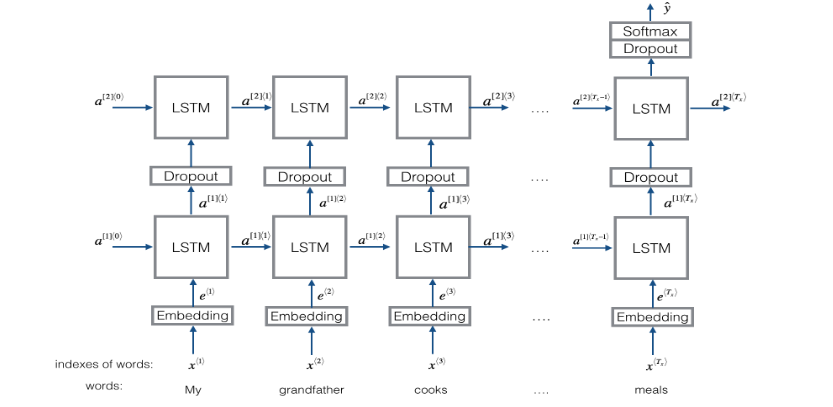



### Keras and mini-batching
In this exercise, we want to train Keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length. This is what allows vectorization to work: If you had a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps) so it's just not possible to do them both at the same time.

The common solution to this is to use padding. Specifically, set a maximum sequence length, and pad all sequences to the same length. For example, of the maximum sequence length is 20, we could pad every sentence with "0"s so that each input sentence is of length 20. Thus, a sentence "i love you" would be represented as  (ei,elove,eyou,0⃗ ,0⃗ ,…,0⃗ )(ei,elove,eyou,0→,0→,…,0→) . In this example, any sentences longer than 20 words would have to be truncated. One simple way to choose the maximum sequence length is to just pick the length of the longest sentence in the training set.

### The Embedding layer
In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, you will learn how to create an Embedding() layer in Keras, initialize it with the GloVe 50-dimensional vectors loaded earlier in the notebook. Because our training set is quite small, we will not update the word embeddings but will instead leave their values fixed. But in the code below, we'll show you how Keras allows you to either train or leave fixed this layer.

The Embedding() layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

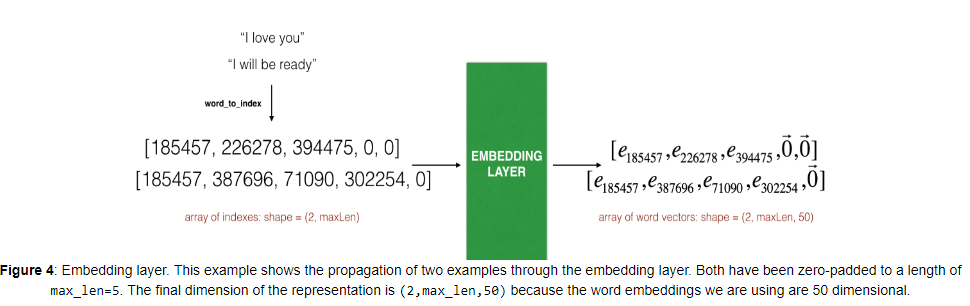

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

The first step is to convert all your training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence.

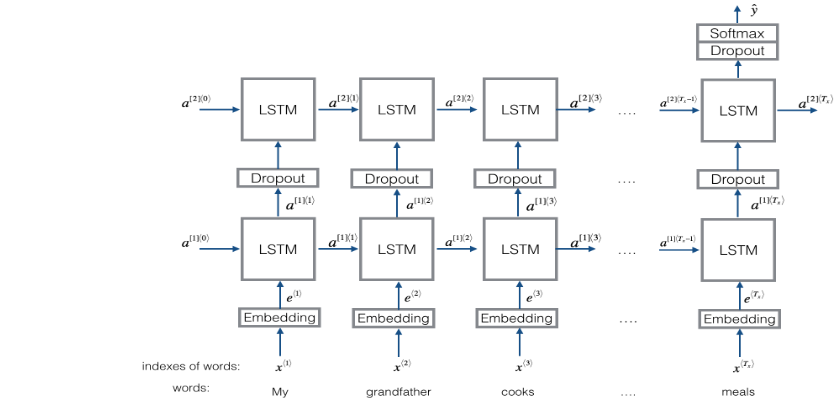
Implement `model_V2()`, which builds a Keras graph of the architecture shown in Figure 3. The model takes as input an array of sentences of shape (`m`, `max_len`, ) defined by `input_shape`. It should output a softmax probability vector of shape (`m`, `C = 5`). You may need `Input(shape = ..., dtype = '...')`, [LSTM()](https://keras.io/layers/recurrent/#lstm), [Dropout()](https://keras.io/layers/core/#dropout), [Dense()](https://keras.io/layers/core/#dense), and [Activation()](https://keras.io/activations/).

In [23]:
def model_v2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the model-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128,return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128,return_sequences = False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(2)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs=X)    
        
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose max_len = 10. You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001*50 = 20,000,050 non-trainable parameters.

### Train and Test

In [31]:
X_train, y_train = mini['text'].astype(str)[:75], mini['label'][:75]
X_test, y_test = mini['text'].astype(str)[75:], mini['label'][75:]
len(X_train)

75

In [25]:

#x = []
'''for i in range(75):
    x.append(len(nltk.tokenize.word_tokenize(X_train[i])))
    
print(maxLen)'''
# Recommended Number of Input LSTM blocks
maxLen = len(max(X_train, key=len).split())
print('The recommended Blocks to be used', maxLen)
maxLen = 600
print('The Blocks Used',maxLen)

The recommended Blocks to be used 6545
The Blocks Used 600


## Kaggle Data

In [26]:
# Preparing X_train_indices and Y_train_oh
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len=maxLen)
Y_train_oh = convert_to_one_hot(y_train, C = 2)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [27]:
# MaxLen taken was 600 instread it should be around 1000 - 2000 who knows?
model = model_v2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 128)          91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
__________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using  categorical_crossentropy loss, adam optimizer and ['accuracy'] metrics:

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. The model takes as input an array of shape (m, max_len) and outputs probability vectors of shape (m, number of classes). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [29]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
75/75 [==============================] - 10s - loss: 0.6879 - acc: 0.4800    
Epoch 2/50
75/75 [==============================] - 9s - loss: 0.6850 - acc: 0.5467     
Epoch 3/50
75/75 [==============================] - 9s - loss: 0.6651 - acc: 0.6400     
Epoch 4/50
75/75 [==============================] - 10s - loss: 0.6690 - acc: 0.5867    
Epoch 5/50
75/75 [==============================] - 9s - loss: 0.6544 - acc: 0.6133     
Epoch 6/50
75/75 [==============================] - 9s - loss: 0.6453 - acc: 0.6133     
Epoch 7/50
75/75 [==============================] - 9s - loss: 0.5989 - acc: 0.6400     
Epoch 8/50
75/75 [==============================] - 9s - loss: 0.5965 - acc: 0.6800     
Epoch 9/50
75/75 [==============================] - 9s - loss: 0.5460 - acc: 0.7200     
Epoch 10/50
75/75 [==============================] - 9s - loss: 0.5581 - acc: 0.6933     
Epoch 11/50
75/75 [==============================] - 9s - loss: 0.5419 - acc: 0.7067     
Epoch 12/50
75/75 [

In [32]:
X_test_indices = sentences_to_indices(X_test.reset_index(drop=True), word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(y_test.reset_index(drop=True), C = 2)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


25/25 [==============================] - 0s

Test accuracy =  0.600000023842


## 30Gb Version

In [33]:
!free -m

             total       used       free     shared    buffers     cached
Mem:         61439      53403       8036        580       1237      34064
-/+ buffers/cache:      18101      43337
Swap:            0          0          0


In [72]:
test = p.read_csv('test.csv')
test.drop(labels='Unnamed: 0',axis =1, inplace=True)
train = p.read_csv('train.csv')
train.drop(labels='Unnamed: 0',axis = 1, inplace=True)
train = train[(train['type'] == 'fake') | (train['type'] == 'reliable')].reset_index(drop = True)
test = test[(test['type'] == 'fake') | (test['type'] == 'reliable')].reset_index(drop = True)

In [77]:
train.head()

,content,type
0,"Facebook/DestinyTheGame Promo image for ""Desti...",reliable
1,"(Screenshot: Facebook) Dr. Melina Abdullah, pr...",reliable
2,(Photo: Reuters) The teams of North and South ...,reliable
3,(Photo: Reuters/Dado Ruvic) Facebook.\n\nUPDAT...,reliable
4,(Screencap: YouTube/Tidningen Dagen) Annahita ...,reliable


In [73]:
type_dic = {'fake':0, 'clickbait': 2, 'reliable': 1} 
f = lambda x: type_dic[x]


In [74]:
train['type'].value_counts()

fake        75
reliable    75
Name: type, dtype: int64

In [75]:
test['type'].value_counts()

fake        30
reliable    30
Name: type, dtype: int64

In [78]:
X_train, y_train = train['content'].astype(str), train['type'].apply(f)
X_test, y_test = test['content'].astype(str), test['type'].apply(f)

In [79]:
# maxLen = len(max(X_train, key=len).split())
maxLen = 300
#for i in range(25):
#    print(len(nltk.tokenize.word_tokenize(X_train[i])))
    
print(maxLen)

300


## Variation 1

In [81]:
# Preparing X_train_indices and Y_train_oh
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len=maxLen)
Y_train_oh = convert_to_one_hot(y_train, C = 2)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [83]:
# MaxLen taken was 20 instread it should be around 1000 - 2000 
model = model_v2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 50)           20000050  
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 128)          91648     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
__________

In [84]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [85]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 10, shuffle=True)

Epoch 1/50
150/150 [==============================] - 16s - loss: 0.6735 - acc: 0.6133    
Epoch 2/50
150/150 [==============================] - 16s - loss: 0.6411 - acc: 0.6267    
Epoch 3/50
150/150 [==============================] - 15s - loss: 0.6022 - acc: 0.7400    
Epoch 4/50
150/150 [==============================] - 15s - loss: 0.5587 - acc: 0.7200    
Epoch 5/50
150/150 [==============================] - 15s - loss: 0.4904 - acc: 0.7333    
Epoch 6/50
150/150 [==============================] - 16s - loss: 0.4216 - acc: 0.8133    
Epoch 7/50
150/150 [==============================] - 15s - loss: 0.3757 - acc: 0.8200    
Epoch 8/50
150/150 [==============================] - 15s - loss: 0.3867 - acc: 0.8600    
Epoch 9/50
150/150 [==============================] - 15s - loss: 0.3707 - acc: 0.8467    
Epoch 10/50
150/150 [==============================] - 15s - loss: 0.3702 - acc: 0.8467    
Epoch 11/50
150/150 [==============================] - 15s - loss: 0.3555 - acc: 0.8467  

In [87]:
X_test_indices = sentences_to_indices(X_test.reset_index(drop=True), word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(y_test.reset_index(drop=True), C = 2)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


60/60 [==============================] - 1s     

Test accuracy =  0.733333345254


### Variation 2

In [94]:
maxLen = 600
# Preparing X_train_indices and Y_train_oh
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len=maxLen)
Y_train_oh = convert_to_one_hot(y_train, C = 2)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


In [91]:
model = model_v2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 600, 50)           20000050  
_________________________________________________________________
lstm_9 (LSTM)                (None, 600, 128)          91648     
_________________________________________________________________
dropout_9 (Dropout)          (None, 600, 128)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
__________

In [92]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 10, shuffle=True)

Epoch 1/50
150/150 [==============================] - 32s - loss: 0.6945 - acc: 0.5933    
Epoch 2/50
150/150 [==============================] - 32s - loss: 0.6676 - acc: 0.6000    
Epoch 3/50
150/150 [==============================] - 31s - loss: 0.6106 - acc: 0.6733    
Epoch 4/50
150/150 [==============================] - 31s - loss: 0.6989 - acc: 0.6267    
Epoch 5/50
150/150 [==============================] - 31s - loss: 0.6028 - acc: 0.6800    
Epoch 6/50
150/150 [==============================] - 31s - loss: 0.5558 - acc: 0.7000    
Epoch 7/50
150/150 [==============================] - 31s - loss: 0.5031 - acc: 0.7467    
Epoch 8/50
150/150 [==============================] - 31s - loss: 0.4857 - acc: 0.7333    
Epoch 9/50
150/150 [==============================] - 32s - loss: 0.5223 - acc: 0.7333    
Epoch 10/50
150/150 [==============================] - 31s - loss: 0.6717 - acc: 0.7067    
Epoch 11/50
150/150 [==============================] - 31s - loss: 0.5796 - acc: 0.7067  

In [101]:
X_test_indices = sentences_to_indices(X_test.reset_index(drop=True), word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(y_test.reset_index(drop=True), C = 2)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


60/60 [==============================] - 2s     

Test accuracy =  0.699999996026


In [97]:
!free -m

             total       used       free     shared    buffers     cached
Mem:         61439      51752       9687        596       1241      34124
-/+ buffers/cache:      16385      45054
Swap:            0          0          0


Train on First Test on second. 
Sentence Embeddings
cosine_similarity???

Work to be done:
1. Change in batch Size and epoch
2. Train on more Data
3. Use of More complex Network
4. RNN/CNN/GRU
5. Sentence Embedding / Avg. Word Embedding
6. Use a different Pretrained Model.
7. Use of grams if the word is not in model.
8. Headlines and content cohenrence
9. Vary the parameters in increments 
	epoch, mini batch size etc
10. Check GRU and RNN .


---------------------------------------------------------------------
---------------------------------------------------------------------

Results:

1. Basic Feed Forward Network (?): 70  Train Cases 30 Test Cases
				Accuracy - 66%
 (The Dataset used was Kaggle one)

2. LSTM : Train Data contained -  75
	   Test Data contained - 25
		Accuracy - 69%  
		epoch - 50
		maxlen - 200
 (The Dataset used was Kaggle one)

3. LSTM : Train Data contained -  75
	   Test Data contained - 25
		Accuracy - 60%  
		epoch - 50
		maxlen - 600 (made worse ? )
 (The Dataset used was Kaggle one)

4. LSTM : Train Data contained -  Fake(75), clickbait(75), reliable(75)
	   Test Data contained - Fake (30), clickbait(30), reliable(30),
		Accuracy - around sixty
		epoch - 50
		maxlen - 300
 (30 Gb one was used)

5. LSTM : Train Data contained -  Fake(75), reliable(75)
	   Test Data contained - Fake (30), reliable(30),
		Accuracy - 73
		epoch - 50
		maxlen - 300

 (30 Gb one was used)
		
6. LSTM : Train Data contained -  Fake(75), reliable(75)
	   Test Data contained - Fake (30), reliable(30),
		Accuracy - 69
		epoch - 50
		maxlen - 600

 (30 Gb one was used)

In [ ]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    ### START CODE HERE ###
    # Compute the dot product between u and v (≈1 line)
    dot = np.dot(u,v)
    # Compute the L2 norm of u (≈1 line)
    norm_u = np.sqrt(np.sum(np.square(u)))
    
    # Compute the L2 norm of v (≈1 line)
    norm_v = np.sqrt(np.sum(np.square(v)))
    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = dot / (norm_u * norm_v)
    ### END CODE HERE ###
    
    return cosine_similarity

In [ ]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))